In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

GRT_QUERY_ENDPOINT = "https://api.thegraph.com/subgraphs/name/convex-community/volume-xdai-test"

def grt_query(query):
    r = requests.post(GRT_QUERY_ENDPOINT, json={'query': query})
    return r.json()['data']

pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
fee_query = """
{ pools(first: 1000) {
  isV2
  id
  name
  dailyPoolSnapshots(first: 1000 orderBy: timestamp orderDirection: desc) {
    timestamp
    adminFeesUSD
    lpFeesUSD
    totalDailyFeesUSD
    eventFeesUSD
    baseApr
    tvl
  }
}
}
"""

In [3]:
data = grt_query(fee_query)['pools']
df = pd.DataFrame([{k: v for k, v in dict({key: val for key, val in entry.items() if key in ['id', 'isV2', 'name']}, **snapshot).items()} for entry in data for snapshot in entry['dailyPoolSnapshots']])
df['totalDailyFeesUSD'] = df['totalDailyFeesUSD'].astype(float)
df['eventFeesUSD'] = df['eventFeesUSD'].astype(float) * 2
df['timestamp'] = pd.to_datetime(df['timestamp'],unit='s')
df = df.sort_values('timestamp', ascending=True)
df

,isV2,id,name,timestamp,adminFeesUSD,lpFeesUSD,totalDailyFeesUSD,eventFeesUSD,baseApr,tvl
249,False,0x7f90122bf0700f9e7e1f688fe926940e8839f353,Curve.fi wxDAI/USDC/USDT,2022-02-21,0,0,0.00,0.00,0,96218270.482642490221765287
248,False,0x7f90122bf0700f9e7e1f688fe926940e8839f353,Curve.fi wxDAI/USDC/USDT,2022-02-22,6.875921613668857702707992838579188,6.875921613668857702707992838579192,13.75,0.00,0.00000007145788618677231983373349910097563,96223411.86663411573720412673310795
247,False,0x7f90122bf0700f9e7e1f688fe926940e8839f353,Curve.fi wxDAI/USDC/USDT,2022-02-23,440.6188075458339418062383232213282,440.6188075458339418062383232213282,881.24,0.00,0.000004764100714202744310723010257765489,92487299.06827126495252525779754466
246,False,0x7f90122bf0700f9e7e1f688fe926940e8839f353,Curve.fi wxDAI/USDC/USDT,2022-02-24,433.5470510510565916127541273360251,433.5470510510565916127541273360251,867.09,0.00,0.000004431667892361587944614870906770258,97829318.79853118950848501044297299
245,False,0x7f90122bf0700f9e7e1f688fe926940e8839f353,Curve.fi wxDAI/USDC/USDT,2022-02-25,534.5470507534966050669174670075772,534.5470507534966050669174670075768,1069.09,0.00,0.000004999005167794029695453021552189664,106930685.768701159898483645480816
...,...,...,...,...,...,...,...,...,...,...
610,False,0xe5f32a099eb90ddb97f3684fc6663dd253dfae55,Curve.fi Factory Plain Pool: USDC/AMIS,2022-07-21,0.0003031018942677933088512912879711371,0.0003031018942677933088512912879711371,0.00,0.00,0.00001505132366778793803232820940823864,20.13788959415418434966745150542795
428,False,0xbdf4488dcf7165788d438b62b4c8a333879b7078,Curve.fi Factory Plain Pool: sGNO/GNO,2022-07-21,0.1068033040399026662372705720692169,0.1068033040399026662372705720692169,0.21,0.00,0.0000000310947145180697460821182063054211,3434773.584360685470140141258571533
527,False,0xd7468e6c3c9259010d1148f79788ba631b94b506,Curve.fi Factory Plain Pool: yearn Curve.fi DA...,2022-07-21,0,0,0.00,0.00,0,0.3281334609914507985213449600407784
604,False,0xe4194fe60c506abb447815e92fb10f3723c55e84,Curve.fi Factory Plain Pool: Basepool (BSC),2022-07-21,0,0,0.00,0.00,0,449.8541547699082572876326508600271


<AxesSubplot:xlabel='timestamp'>

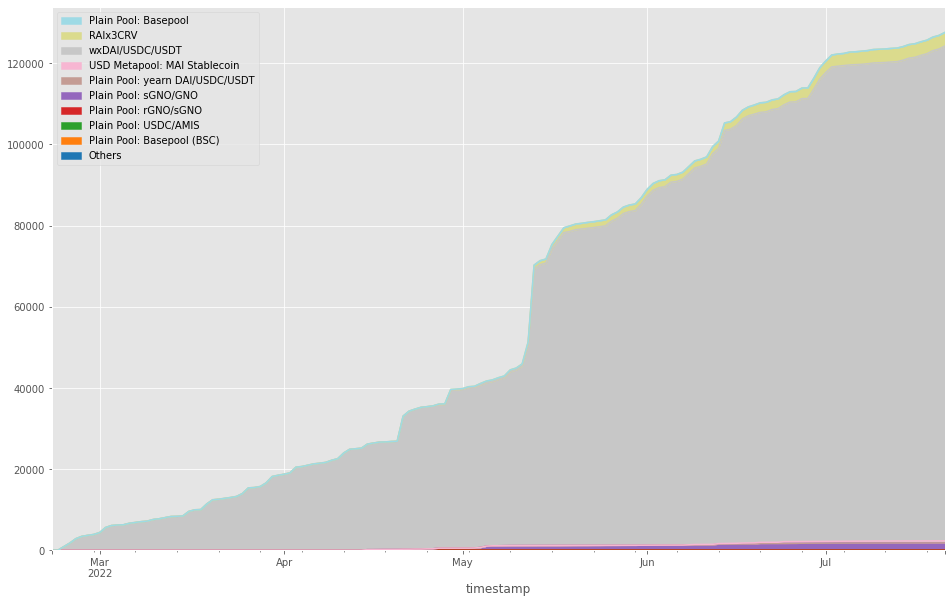

In [7]:
df['cumulativeDailyFeesUSD'] = (df['totalDailyFeesUSD']).groupby(df['id']).cumsum()
chart_data = df[['name', 'timestamp', 'cumulativeDailyFeesUSD']].pivot_table('cumulativeDailyFeesUSD', ['timestamp'], 'name', aggfunc='sum')
top_performers = chart_data.mean().sort_values(ascending=False)[:19].index.tolist()
df_others = df.copy()
df_others['name'] = df_others['name'].apply(lambda x: x if x in top_performers else 'Others')
df['cumulativeDailyFeesUSD'] = (df['totalDailyFeesUSD']).groupby(df['id']).cumsum()
chart_data_others = df_others[['name', 'timestamp', 'cumulativeDailyFeesUSD']].pivot_table('cumulativeDailyFeesUSD', ['timestamp'], 'name', aggfunc='sum')
chart_data_others['Others'] = df_others[df_others['name'] == 'Others'][['timestamp', 'cumulativeDailyFeesUSD']].groupby('timestamp').sum()['cumulativeDailyFeesUSD']
chart_data_others.columns = [s.replace('Curve.fi Factory ', '').replace('Curve.fi ', '').replace('Curve ', '') for s in chart_data_others.columns]
cols = chart_data_others.columns.tolist()
chart_data_others[([cols[-1], *cols[1:-1], cols[0]])].plot.area(figsize=(16, 10), legend='reverse', colormap="tab20")

In [5]:
WEEK = 3600 * 24 * 7
df_week = pd.DataFrame([{k: v for k, v in dict({key: val for key, val in entry.items() if key in ['id', 'isV2', 'name']}, **snapshot).items()} for entry in data for snapshot in entry['dailyPoolSnapshots']])
df_week['totalDailyFeesUSD'] = df_week['totalDailyFeesUSD'].astype(float)
df_week['timestamp'] = df_week['timestamp'].apply(lambda x: ((int(x) // WEEK) * WEEK))
df_week['timestamp'] = pd.to_datetime(df_week['timestamp'],unit='s')
df_week = df_week.sort_values('timestamp', ascending=True)
df_week[['totalDailyFeesUSD', 'timestamp', 'name', 'id']].groupby(['timestamp']).sum()

,totalDailyFeesUSD
timestamp,
2022-02-17,894.99
2022-02-24,4696.49
2022-03-03,1572.84
2022-03-10,2403.92
2022-03-17,3421.26
2022-03-24,5170.92
2022-03-31,3121.23
2022-04-07,3715.05
2022-04-14,1860.88


In [6]:
df_week[['totalDailyFeesUSD', 'timestamp', 'name', 'id']].groupby(['timestamp']).sum().sum() / 2

totalDailyFeesUSD   63803.61
dtype: float64